Celem naszego projektu jest zaprojektowanie i implementacja algorytmu służącego do odszumiania dźwięku. Aby to osiągnąć zdecydowaliśmy się na zastosowanie autoencodera, który na podstawie wejścia z zaszumionym dźwiękiem jest w stanie ten szum usunąć. Przy implementacji zdecydowaliśmy się na technologię python z wykorzystaniem biblioteki pytorch do uczenia maszynowego.

Auto Encoder to samonadzorowana sieć neuronowa, która uczy się, jak kodować dane wejściowe w niższych wymiarach, a następnie ponownie dekodować i rekonstruować dane, aby były jak najbliżej wejścia tak wydajnie, jak to tylko możliwe. Jest ona odporny na szumy zakodowane w domenie.

Autoencoder składa się z trzech części:
1.   koder - warstwa, która koduje dane wejściowe do postaci w niższym wymiarze
2.   skompresowana warstwa, która zawiera zakodowaną reprezentację danych wejściowych
3.   dekoder - warstwa, która dekoduje dane do danych wyjściowych

Do głównych zastosowań autoencodera należy denoising, czyli odszumianie, polega ono na tym, aby z zaszumionego obrazu lub dźwięku jako wejścia uzyskać odszumione dane. 

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device=", device)

device= cpu


![image.png](formula.png)

In [2]:
def variational_loss(mu, std):
    vl=-0.5*torch.sum(1+ 2*torch.log(std)-mu.pow(2) -(std.pow(2)))
    return vl
   
def variational_loss2(mu, std):
    #returns the variational loss from arguments mean and standard deviation std
    vl=torch.mean(mu.pow(2)+(1-std).pow(2))
    return vl

Porównanie naszego "variational loss" ze zwykłym błędem średniokwadratowym dla mi=0 i std=1

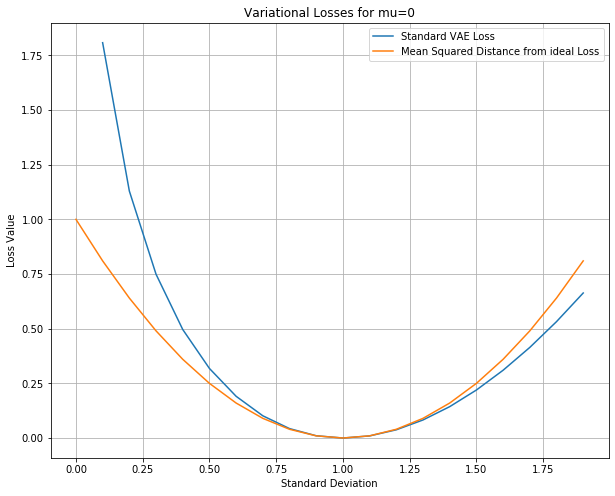

In [3]:
std=np.arange(0,20)
vloss=torch.zeros(std.shape)
vloss2=torch.zeros(std.shape)
for std_ in std:
    vloss[std_]=variational_loss(torch.tensor([0.0]),torch.tensor(0.1*std_))
    vloss2[std_]=variational_loss2(torch.tensor([0.0]),torch.tensor([0.1*std_]))

plt.figure(figsize=(10,8))
plt.plot(0.1*std,np.array(vloss))
plt.plot(0.1*std,np.array(vloss2))
plt.ylabel('Loss Value')
plt.xlabel('Standard Deviation')
plt.title('Variational Losses for mu=0')
plt.legend(('Standard VAE Loss', 'Mean Squared Distance from ideal Loss'))
plt.grid()

Tutaj widzimy, że obie funkcje straty mają to samo minimum na std=1. Widzimy jednak, że standardowa strata VAE ma bardziej stromy wzrost w kierunku niższych wariancji i mniejszy wzrost w kierunku wyższych wariancji.

Mamy teraz do przeszkolenia dwa wyjścia sieciowe:

Yencmean=model.encodermean(X), który odpowiada naszemu koderowi, oraz
Yencstd=model.encoderstd(X), który po prostu generuje aktualnie „dopuszczalne” odchylenie standardowe dla każdego „średniego” wyniku podczas procesu uczenia.

Nasza funkcja straty składa się z dwóch składników, dlatego łączymy je w pętli treningowej za pomocą „mnożnika Lagrange'a”, aby połączyć je w ogólną wartość straty.

Mnożnik Lagrange'a po prostu waży dwa składniki, aby osiągnąć pożądany kompromis między nimi. W naszym przypadku wygląda to tak:

![image.PNG](1.PNG)

gdzie współczynnik "0,01" to nasz mnożnik Lagrange'a.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import scipy.io.wavfile as wav

In [5]:
import pickle
   
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device=", device)   

device= cpu


In [6]:
def signal2pytorch(x):
    #Function to convert a signal vector x, like a mono audio signal, into a 3-d Tensor that conv1d of Pytorch expects,
    
    X = np.expand_dims(x, axis=0)  
    if len(x.shape)==1: #mono:
        X = np.expand_dims(X, axis=0)  
    X=torch.from_numpy(X)
    X=X.type(torch.Tensor)
    X=X.permute(1,0,2)  
    return X

In [7]:
class Convautoenc(nn.Module):
    def __init__(self):
        super(Convautoenc, self).__init__()
        self.conv1mean=nn.Conv1d(in_channels=1, out_channels=32, kernel_size=8*2048, stride=8*1024, padding=8*1024-1, bias=True) #Padding for 'same' filters (kernel_size/2-1)
        self.conv1std=nn.Conv1d(in_channels=1, out_channels=32, kernel_size=8*2048, stride=8*1024, padding=8*1024-1, bias=True) #Padding for 'same' filters (kernel_size/2-1)
        
        self.synconv1=nn.ConvTranspose1d(in_channels=32, out_channels=1, kernel_size=8*2048, stride=8*1024, padding=8*1024-1, bias=True)

    def encodermean(self, x):
        x = self.conv1mean(x)
        y = torch.tanh(x)
        return y
      
    def encoderstd(self, x):
        x = self.conv1std(x)
        y = torch.abs(torch.tanh(x))
        return y
      
    def decoder(self, y):
        xrek= self.synconv1(y)
        return xrek
      
    def forward(self, x):
        Yencmean=model.encodermean(x)
        Yencstd=model.encoderstd(x)
        Yvariational= Yencmean + Yencstd*torch.randn_like(Yencstd)
        Ypred=model.decoder(Yvariational)
        return Ypred, Yencmean, Yencstd

In [8]:
import librosa

W naszym programie korzystamy z plików dźwiękowych, do których następnie dokładany jest szum.

In [9]:
#alternative: speech:
#make training set with batch of 2 speech signals:
batch=2;
x0, fs = librosa.load("./Iron Maiden - The Number Of The Beast.mp3", mono=True, sr=None, duration=6, offset=13)
xlen=max(x0.shape)
x=np.zeros((batch,xlen))
for b in range(batch):
    if b==0: 
        x0, fs = librosa.load("./Iron Maiden - The Number Of The Beast.mp3", mono=True, sr=None, duration=6, offset=13)
    if b==1:
        x0, fs = librosa.load("./Iron Maiden - Aces High.mp3", mono=True, sr=None, duration=6, offset=8)
    x0= x0/max(x0)
    x[b,:]=x0
    print("x.shape=", x.shape)
    X=signal2pytorch(x).to(device) #Convert to pytorch format, batch is first dimension    
    print("X.shape=", X.shape)
    print("Generate Model:")
    model = Convautoenc().to(device)
    print('Total number of parameters: %i' % (sum(p.numel() for p in model.parameters() if p.requires_grad)))
    print("Def. loss function:")
    loss_fn = nn.MSELoss()  #MSE

D:\Anaconda\Anaconda\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


x.shape= (2, 288000)
X.shape= torch.Size([2, 1, 288000])
Generate Model:
Total number of parameters: 1572929
Def. loss function:
x.shape= (2, 288000)
X.shape= torch.Size([2, 1, 288000])
Generate Model:
Total number of parameters: 1572929
Def. loss function:


In [10]:
Ypred, Yencmean, Yencstd = model(X)
    
outputlen=len(Ypred[0,0,:]) 
print("outputlen=", outputlen)
    
Y=X[:,:,:outputlen]  
    
print("Input X.shape=", X.shape )
print("Target Y.shape=", Y.shape)
print("Target Y=", Y)
print("Y.type()=", Y.type())
        
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)#, betas=(0.9, 0.999))

randdir=False

outputlen= 286722
Input X.shape= torch.Size([2, 1, 288000])
Target Y.shape= torch.Size([2, 1, 286722])
Target Y= tensor([[[ 4.6740e-05,  5.1414e-04,  4.6740e-04,  ..., -1.8229e-03,
          -2.2435e-03, -1.9163e-03]],

        [[ 2.2972e-03,  3.3140e-02,  7.2711e-02,  ..., -1.1406e-02,
          -4.9939e-04,  4.9340e-03]]])
Y.type()= torch.FloatTensor


In [11]:
def variational_loss(mu, std):
    #returns the varialtional loss from arguments mean and standard deviation std
    vl=-0.5*torch.mean(1+ 2*torch.log(std)-mu.pow(2) -(std.pow(2)))
    return vl
   
def variational_loss2(mu, std):
    #returns the varialtional loss from arguments mean and standard deviation std
    vl=torch.mean(mu.pow(2)+(1-std).pow(2))
    return vl

In [12]:
if randdir==True:
    #optimization of weights using method of random directions:
    optimrandomdir_pytorch.optimizer(model, loss_fn, X, Y, iterations=100000, startingscale=0.25, endscale=0.0)
    #--End optimization of random directions------------------------
else:
    for epoch in range(2000):
        Yencmean=model.encodermean(X)
          
        Yencstd=model.encoderstd(X)
          
        Yvariational= Yencmean + Yencstd*torch.randn_like(Yencstd)
        Ypred=model.decoder(Yvariational)
          
        mse=loss_fn(Ypred, Y)
        vl=variational_loss(Yencmean, Yencstd)
        loss= mse + 0.01*vl
        if epoch%10==0:
             print(epoch, "mse=", mse.item(), "variational loss=", vl.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #"""
    torch.save({#'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()}, "audio_variational_autoenc.torch")
    #"""
    

0 mse= 0.011216526851058006 variational loss= 3.397057294845581
10 mse= 0.011005823500454426 variational loss= 2.178765296936035
20 mse= 0.01035667397081852 variational loss= 1.8097782135009766
30 mse= 0.009565034881234169 variational loss= 1.6123688220977783
40 mse= 0.008746149018406868 variational loss= 1.483839511871338
50 mse= 0.008042016066610813 variational loss= 1.387776494026184
60 mse= 0.007360005285590887 variational loss= 1.3121240139007568
70 mse= 0.006764169782400131 variational loss= 1.2484010457992554
80 mse= 0.006501446943730116 variational loss= 1.1933515071868896
90 mse= 0.0061219194903969765 variational loss= 1.1459684371948242
100 mse= 0.005940041039139032 variational loss= 1.1040502786636353
110 mse= 0.005724530667066574 variational loss= 1.0671451091766357
120 mse= 0.005430890247225761 variational loss= 1.0330941677093506
130 mse= 0.004958098288625479 variational loss= 1.0022047758102417
140 mse= 0.004903330467641354 variational loss= 0.9730606079101562
150 mse= 0

1220 mse= 0.004358564969152212 variational loss= 0.46422210335731506
1230 mse= 0.00426439056172967 variational loss= 0.4630826711654663
1240 mse= 0.004330658353865147 variational loss= 0.46190345287323
1250 mse= 0.004420886747539043 variational loss= 0.46053606271743774
1260 mse= 0.004381008446216583 variational loss= 0.4595804810523987
1270 mse= 0.0043186829425394535 variational loss= 0.4575066566467285
1280 mse= 0.004044478293508291 variational loss= 0.4564633369445801
1290 mse= 0.004385816399008036 variational loss= 0.4553256630897522
1300 mse= 0.004115215968340635 variational loss= 0.45399194955825806
1310 mse= 0.00393668795004487 variational loss= 0.45316457748413086
1320 mse= 0.004241191782057285 variational loss= 0.45159217715263367
1330 mse= 0.004210151731967926 variational loss= 0.4501623511314392
1340 mse= 0.0042177289724349976 variational loss= 0.44938012957572937
1350 mse= 0.004124009050428867 variational loss= 0.4483320415019989
1360 mse= 0.004825026728212833 variational l

In [13]:
print("MSE=", loss_fn(Ypred, Y).item(), "Variational Loss:", variational_loss(Yencmean, Yencstd).item())
ww = model.state_dict()   #read obtained weights
print("ww=", ww)
#Plot obtained weights:
plt.figure(figsize=(10,8))
plt.plot(np.transpose(np.array(ww['conv1mean.weight'][0:1,0,:])))
plt.plot(np.transpose(np.array(ww['conv1std.weight'][0:1,0,:])))
plt.plot(np.transpose(np.array(ww['synconv1.weight'][0:1,0,:])))
plt.legend(('Encoder Analysis filter 0, mean','Encoder Analysis filter 0, std', 'Decoder Filter 0'))
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('The Encoder and Decoder Filter Coefficients')
plt.grid()

MSE= 0.004386758431792259 Variational Loss: 0.39969176054000854
ww= OrderedDict([('conv1mean.weight', tensor([[[ 1.0869e-02, -3.2267e-05,  1.0962e-03,  ...,  7.4595e-05,
           8.4491e-04,  1.6816e-03]],

        [[-1.0602e-02, -6.7008e-03, -1.1043e-02,  ...,  3.2047e-03,
          -7.2625e-03, -1.0039e-02]],

        [[ 5.2819e-03, -5.1887e-04,  2.0565e-03,  ..., -1.2480e-02,
          -2.3108e-03, -3.5631e-03]],

        ...,

        [[-1.8731e-03,  7.3993e-03, -5.1660e-03,  ..., -5.9987e-03,
          -1.1352e-02, -2.6279e-03]],

        [[-9.3300e-03, -4.4648e-03,  7.7728e-04,  ..., -5.7756e-03,
          -4.8704e-03,  4.1160e-03]],

        [[ 1.6987e-03,  7.4465e-03,  1.3267e-03,  ...,  1.1083e-02,
           6.7124e-03,  7.1022e-03]]])), ('conv1mean.bias', tensor([-0.0033, -0.0064, -0.0026,  0.0026,  0.0037, -0.0080,  0.0007,  0.0068,
        -0.0015, -0.0045,  0.0033, -0.0015,  0.0022, -0.0043, -0.0093, -0.0018,
         0.0004,  0.0005,  0.0016,  0.0021, -0.0038,  0.0056,

Po nauczeniu program najpierw wyświetla wagi autoenkodera i dekodera, a następnie rysuje wykres współczynników filtrowania enkodera i dekodera.

In [14]:
#Test on training set:
Yencmean=model.encodermean(X)
    
#no noise case
predclean=model.decoder(Yencmean)
predclean=predclean.detach() #no noise case
predclean=np.array(predclean)
    
#Add gaussian noise with unit standard deviation to encoded signal:
Yvariational= Yencmean + torch.randn_like(Yencmean)
predictions=model.decoder(Yvariational)
    
predictions=predictions.detach()
predictions=np.array(predictions)
Yencmean=np.array(Yencmean.detach())
Yencstd=np.array(Yencstd.detach())
print("Yencstd.shape=",Yencstd.shape)
    
Y=np.array(Y) #target
print("predictions.shape=", predictions.shape)

Yencstd.shape= (2, 32, 36)
predictions.shape= (2, 1, 286722)


In [15]:
import IPython.display as ipd

"The training set output for clean encoded signal for batch0"


"The training set output for noisy encoded signal for batch0"


"The training set output for clean encoded signal for batch1"


"The training set output for noisy encoded signal for batch1"


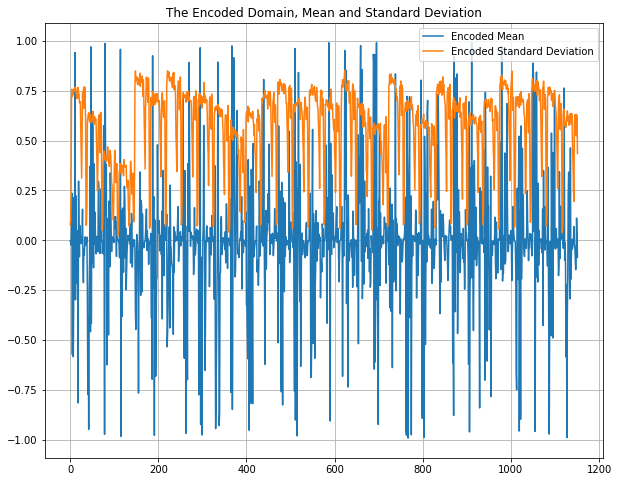

D:\Anaconda\Anaconda\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


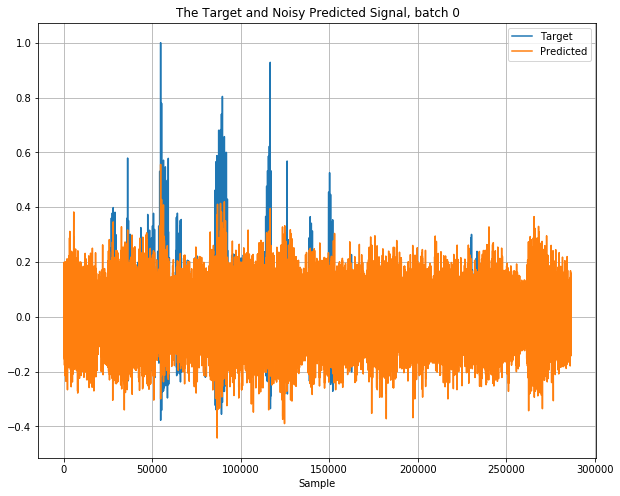

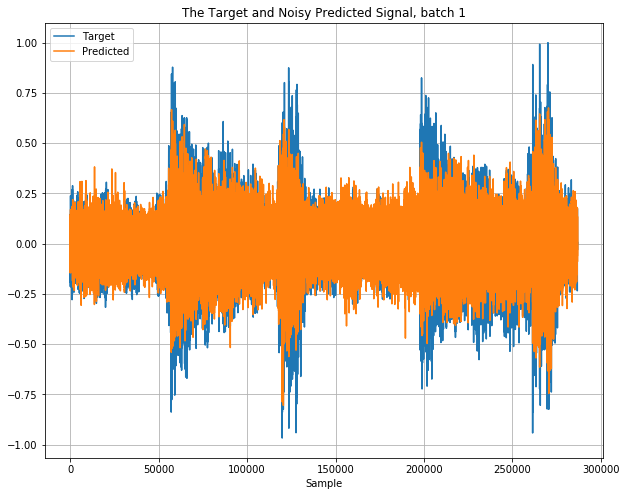

In [16]:
#Plot target signal and output of autoencoder:

for b in range(batch):
    plt.figure(figsize=(10,8))
    plt.plot(np.reshape(Yencmean[b,:,:],(1,-1))[0,:])
    plt.plot(np.reshape(Yencstd[b,:,:],(1,-1))[0,:])
    plt.legend(('Encoded Mean', 'Encoded Standard Deviation'))
    plt.title('The Encoded Domain, Mean and Standard Deviation')
    plt.grid()
    plt.figure(figsize=(10,8))
    plt.plot(np.array(Y[b,0,:]))
    plt.plot(predictions[b,0,:])
    plt.legend(('Target','Predicted'))
    plt.title('The Target and Noisy Predicted Signal, batch '+str(b))
    plt.xlabel('Sample')
    plt.grid()

    #No noise case:
    xrek=predclean[b,0,:]  
    xrek=np.clip(xrek, -1.0,1.0)
    wav.write('testrekvaeclean'+str(b)+'.wav', fs, np.int16(2**15*xrek))
    print('"The training set output for clean encoded signal for batch'+str(b)+'"')
    display(ipd.Audio(2**15*xrek,rate=fs))
      
    xrek=predictions[b,0,:]  
    xrek=np.clip(xrek, -1.0,1.0)
    wav.write('testrekvae'+str(b)+'.wav', fs, np.int16(2**15*xrek))
    print('"The training set output for noisy encoded signal for batch'+str(b)+'"')
    display(ipd.Audio(2**15*xrek,rate=fs))

Wykorzystanie funkcji <br>
vl=variational_loss2(Yencmean, Yencstd)

D:\Anaconda\Anaconda\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


The verification set input to the variational autoencoder


The verification set output for clean encoded signal


The verification set output for noisy encoded signal


Only noise as encoded signal
The decoded signal


D:\Anaconda\Anaconda\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


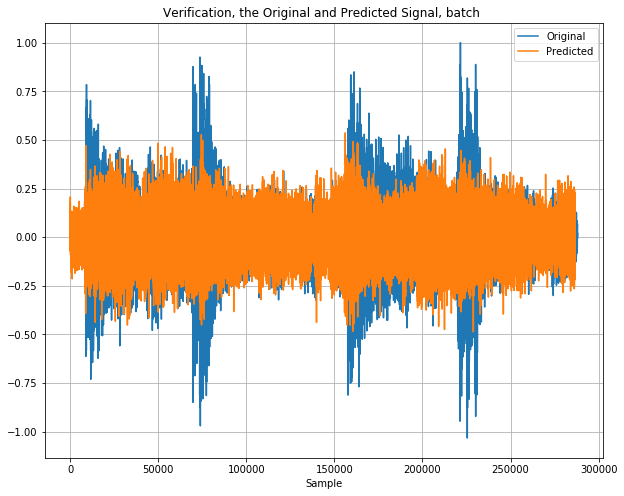

In [17]:
#Test on Verification set:
x, fs = librosa.load("./Iron Maiden - Aces High.mp3", mono=True, sr=None, duration=6, offset=0)
x=x/max(x)
    
print("The verification set input to the variational autoencoder")
display(ipd.Audio(2**14*x,rate=fs))
X=signal2pytorch(x).to(device)
Yencmean=model.encodermean(X)

predclean=model.decoder(Yencmean)
predclean=predclean.detach() #no noise case
predclean=np.array(predclean)
    
#No noise case:
xrek=predclean[0,0,:]  #remove unnecessary dimension for playback
xrek=np.clip(xrek, -1.0,1.0)
wav.write('testvervaeclean'+str(b)+'.wav', fs, np.int16(2**15*xrek))
print("The verification set output for clean encoded signal")
display(ipd.Audio(2**15*xrek, rate=fs))
    
#Add gaussian noise with unit standard deviation:
Yvariational= Yencmean + torch.randn_like(Yencmean)
predictions= model.decoder(Yvariational)
predictions=predictions.detach()
predictions=np.array(predictions)
b=0
plt.figure(figsize=(10,8))
plt.plot(np.array(X[b,0,:]))
plt.plot(predictions[b,0,:])
plt.legend(('Original','Predicted'))
plt.title('Verification, the Original and Predicted Signal, batch ')
plt.xlabel('Sample')
plt.grid()
xrek=predictions[:,0,:]
xrek=np.transpose(xrek)
xrek=np.clip(xrek, -1.0,1.0)
wav.write('testver.wav', fs, np.int16(2**15*xrek))
print("The verification set output for noisy encoded signal")
display(ipd.Audio('testver.wav', rate=fs))
print("Only noise as encoded signal")

Yvariational=  torch.randn_like(Yencmean)
predictions= model.decoder(Yvariational) 
predictions=predictions.detach()
predictions=np.array(predictions)
xrek=predictions[:,0,:]
xrek=np.transpose(xrek)
xrek=np.clip(xrek, -1.0,1.0)
wav.write('noisevarout.wav', fs, np.int16(2**15*xrek))
print("The decoded signal")
display(ipd.Audio('noisevarout.wav', rate=fs))

In [18]:
#make training set with batch of 2 speech signals:
batch=2;
x0, fs = librosa.load("./Iron Maiden - The Number Of The Beast.mp3", mono=True, sr=None, duration=6, offset=13)
xlen=max(x0.shape)
x=np.zeros((batch,xlen))
for b in range(batch):
    if b==0: 
        x0, fs = librosa.load("./Iron Maiden - The Number Of The Beast.mp3", mono=True, sr=None, duration=6, offset=13)
    if b==1:
        x0, fs = librosa.load("./Iron Maiden - Aces High.mp3", mono=True, sr=None, duration=6, offset=8)
    x0= x0/max(x0)
    x[b,:]=x0
    #x=x*1.0/2**15 #normalize
    print("x.shape=", x.shape)
    X=signal2pytorch(x).to(device)     
    print("X.shape=", X.shape)
    print("Generate Model:")
    model = Convautoenc().to(device)
    print('Total number of parameters: %i' % (sum(p.numel() for p in model.parameters() if p.requires_grad)))
    print("Def. loss function:")
    loss_fn = nn.MSELoss()  

D:\Anaconda\Anaconda\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


x.shape= (2, 288000)
X.shape= torch.Size([2, 1, 288000])
Generate Model:
Total number of parameters: 1572929
Def. loss function:
x.shape= (2, 288000)
X.shape= torch.Size([2, 1, 288000])
Generate Model:
Total number of parameters: 1572929
Def. loss function:


In [19]:
Ypred, Yencmean, Yencstd = model(X)
    
outputlen=len(Ypred[0,0,:]) 
print("outputlen=", outputlen)
    
Y=X[:,:,:outputlen]  
    
print("Input X.shape=", X.shape )
print("Target Y.shape=", Y.shape)
print("Target Y=", Y)
print("Y.type()=", Y.type())
        
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)#, betas=(0.9, 0.999))
randdir=False

outputlen= 286722
Input X.shape= torch.Size([2, 1, 288000])
Target Y.shape= torch.Size([2, 1, 286722])
Target Y= tensor([[[ 4.6740e-05,  5.1414e-04,  4.6740e-04,  ..., -1.8229e-03,
          -2.2435e-03, -1.9163e-03]],

        [[ 2.2972e-03,  3.3140e-02,  7.2711e-02,  ..., -1.1406e-02,
          -4.9939e-04,  4.9340e-03]]])
Y.type()= torch.FloatTensor


In [20]:
if randdir==True:
    #optimization of weights using method of random directions:
    optimrandomdir_pytorch.optimizer(model, loss_fn, X, Y, iterations=100000, startingscale=0.25, endscale=0.0)
else:
    for epoch in range(2000):
        Yencmean=model.encodermean(X)
          
        Yencstd=model.encoderstd(X)
          
        Yvariational= Yencmean + Yencstd*torch.randn_like(Yencstd)
        Ypred=model.decoder(Yvariational)
          
        mse=loss_fn(Ypred, Y)
        vl=variational_loss2(Yencmean, Yencstd)
        loss= mse + 0.01*vl 
        if epoch%10==0:
             print(epoch, "mse=", mse.item(), "variational loss=", vl.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #"""
    torch.save({#'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()}, "audio_variational_autoenc.torch")
    #"""
    

0 mse= 0.011219048872590065 variational loss= 0.9278215765953064
10 mse= 0.011224282905459404 variational loss= 0.6926309466362
20 mse= 0.011132242158055305 variational loss= 0.5655315518379211
30 mse= 0.010910925455391407 variational loss= 0.4877074658870697
40 mse= 0.010598374530673027 variational loss= 0.4361354112625122
50 mse= 0.010082886554300785 variational loss= 0.4053694009780884
60 mse= 0.009904987178742886 variational loss= 0.3835674524307251
70 mse= 0.00921368133276701 variational loss= 0.3700508773326874
80 mse= 0.008859501220285892 variational loss= 0.3570463955402374
90 mse= 0.00855106022208929 variational loss= 0.3472258150577545
100 mse= 0.00826218631118536 variational loss= 0.34101998805999756
110 mse= 0.00801531970500946 variational loss= 0.3347848653793335
120 mse= 0.007964965887367725 variational loss= 0.33191776275634766
130 mse= 0.0075194984674453735 variational loss= 0.3279712200164795
140 mse= 0.007452027406543493 variational loss= 0.3200858235359192
150 mse= 0

1220 mse= 0.0051552485674619675 variational loss= 0.35050758719444275
1230 mse= 0.004983090329915285 variational loss= 0.3494911193847656
1240 mse= 0.005513632670044899 variational loss= 0.3494095802307129
1250 mse= 0.0053407540544867516 variational loss= 0.3509742021560669
1260 mse= 0.005171661265194416 variational loss= 0.3512701988220215
1270 mse= 0.0050560664385557175 variational loss= 0.3525581955909729
1280 mse= 0.00539742037653923 variational loss= 0.3521153926849365
1290 mse= 0.005262858234345913 variational loss= 0.3512192666530609
1300 mse= 0.005081898998469114 variational loss= 0.3520984351634979
1310 mse= 0.0052206250838935375 variational loss= 0.35326799750328064
1320 mse= 0.005256881471723318 variational loss= 0.35324543714523315
1330 mse= 0.005099672824144363 variational loss= 0.353112131357193
1340 mse= 0.004981353413313627 variational loss= 0.3521059453487396
1350 mse= 0.005065487697720528 variational loss= 0.35230013728141785
1360 mse= 0.0053094192408025265 variationa

MSE= 0.004282546695321798 Variational Loss: 0.4388423562049866
ww= OrderedDict([('conv1mean.weight', tensor([[[ 0.0034,  0.0071, -0.0010,  ...,  0.0079,  0.0017,  0.0010]],

        [[ 0.0029,  0.0019,  0.0068,  ..., -0.0068,  0.0052, -0.0016]],

        [[ 0.0058,  0.0075,  0.0012,  ...,  0.0024, -0.0064, -0.0034]],

        ...,

        [[ 0.0059,  0.0039, -0.0040,  ..., -0.0028,  0.0087,  0.0021]],

        [[-0.0047,  0.0051,  0.0100,  ...,  0.0012,  0.0033, -0.0021]],

        [[ 0.0072,  0.0097, -0.0043,  ...,  0.0065,  0.0061, -0.0046]]])), ('conv1mean.bias', tensor([-0.0004, -0.0044, -0.0012,  0.0007, -0.0033, -0.0003,  0.0050,  0.0005,
        -0.0007,  0.0006,  0.0045, -0.0021, -0.0033,  0.0011,  0.0001,  0.0004,
         0.0066, -0.0034, -0.0028,  0.0026, -0.0015, -0.0051, -0.0044, -0.0029,
         0.0051, -0.0033, -0.0006,  0.0015,  0.0033,  0.0015, -0.0023,  0.0040])), ('conv1std.weight', tensor([[[ 0.0139,  0.0041,  0.0144,  ..., -0.0011, -0.0058, -0.0042]],

        [[

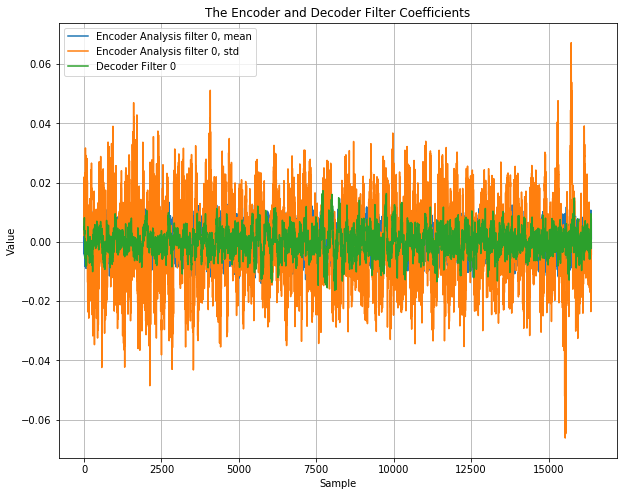

In [21]:
print("MSE=", loss_fn(Ypred, Y).item(), "Variational Loss:", variational_loss(Yencmean, Yencstd).item())
ww = model.state_dict()   #read obtained weights
print("ww=", ww)
#Plot obtained weights:
plt.figure(figsize=(10,8))
plt.plot(np.transpose(np.array(ww['conv1mean.weight'][0:1,0,:])))
plt.plot(np.transpose(np.array(ww['conv1std.weight'][0:1,0,:])))
plt.plot(np.transpose(np.array(ww['synconv1.weight'][0:1,0,:])))
plt.legend(('Encoder Analysis filter 0, mean','Encoder Analysis filter 0, std', 'Decoder Filter 0'))
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('The Encoder and Decoder Filter Coefficients')
plt.grid()

In [22]:
#Test on training set:
    
Yencmean=model.encodermean(X)
    
predclean=model.decoder(Yencmean)
predclean=predclean.detach() #no noise case
predclean=np.array(predclean)
    
Yvariational= Yencmean + torch.randn_like(Yencmean)
predictions=model.decoder(Yvariational)
    
predictions=predictions.detach()
predictions=np.array(predictions)
Yencmean=np.array(Yencmean.detach())
Yencstd=np.array(Yencstd.detach())
print("Yencstd.shape=",Yencstd.shape)
    
Y=np.array(Y) 
print("predictions.shape=", predictions.shape)

Yencstd.shape= (2, 32, 36)
predictions.shape= (2, 1, 286722)


In [23]:
import IPython.display as ipd

"The training set output for clean encoded signal for batch0"


"The training set output for noisy encoded signal for batch0"


"The training set output for clean encoded signal for batch1"


"The training set output for noisy encoded signal for batch1"


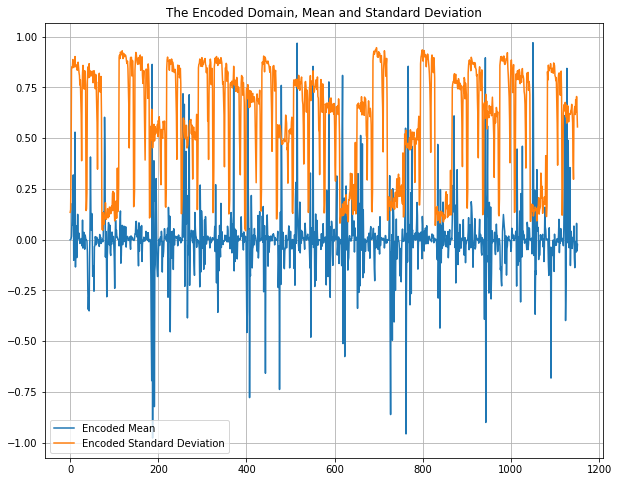

D:\Anaconda\Anaconda\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


In [ ]:
#Plot target signal and output of autoencoder:

for b in range(batch):
    plt.figure(figsize=(10,8))
    plt.plot(np.reshape(Yencmean[b,:,:],(1,-1))[0,:])
    plt.plot(np.reshape(Yencstd[b,:,:],(1,-1))[0,:])
    plt.legend(('Encoded Mean', 'Encoded Standard Deviation'))
    plt.title('The Encoded Domain, Mean and Standard Deviation')
    plt.grid()
    plt.figure(figsize=(10,8))
    plt.plot(np.array(Y[b,0,:]))
    plt.plot(predictions[b,0,:])
    plt.legend(('Target','Predicted'))
    plt.title('The Target and Noisy Predicted Signal, batch '+str(b))
    plt.xlabel('Sample')
    plt.grid()

    xrek=predclean[b,0,:]  
    xrek=np.clip(xrek, -1.0,1.0)
    wav.write('testrekvaeclean'+str(b)+'.wav', fs, np.int16(2**15*xrek))
    print('"The training set output for clean encoded signal for batch'+str(b)+'"')
    display(ipd.Audio(2**15*xrek,rate=fs))
      
    xrek=predictions[b,0,:]  
    xrek=np.clip(xrek, -1.0,1.0)
    wav.write('testrekvae'+str(b)+'.wav', fs, np.int16(2**15*xrek))
    print('"The training set output for noisy encoded signal for batch'+str(b)+'"')
    display(ipd.Audio(2**15*xrek,rate=fs))

In [ ]:
x, fs = librosa.load("./Iron Maiden - Aces High.mp3", mono=True, sr=None, duration=6, offset=0)
x=x/max(x)
    
print("The verification set input to the variational autoencoder")
display(ipd.Audio(2**14*x,rate=fs))
X=signal2pytorch(x).to(device)
Yencmean=model.encodermean(X)

predclean=model.decoder(Yencmean)
predclean=predclean.detach() 
predclean=np.array(predclean)
    
xrek=predclean[0,0,:]  
xrek=np.clip(xrek, -1.0,1.0)
wav.write('testvervaeclean'+str(b)+'.wav', fs, np.int16(2**15*xrek))
print("The verification set output for clean encoded signal")
display(ipd.Audio(2**15*xrek, rate=fs))
    
Yvariational= Yencmean + torch.randn_like(Yencmean)
predictions= model.decoder(Yvariational) 
predictions=predictions.detach()
predictions=np.array(predictions)
b=0
plt.figure(figsize=(10,8))
plt.plot(np.array(X[b,0,:]))
plt.plot(predictions[b,0,:])
plt.legend(('Original','Predicted'))
plt.title('Verification, the Original and Predicted Signal, batch ')
plt.xlabel('Sample')
plt.grid()
xrek=predictions[:,0,:]
xrek=np.transpose(xrek)
xrek=np.clip(xrek, -1.0,1.0)
wav.write('testver.wav', fs, np.int16(2**15*xrek))
print("The verification set output for noisy encoded signal")
display(ipd.Audio('testver.wav', rate=fs))
print("Only noise as encoded signal")

Yvariational=  torch.randn_like(Yencmean)
predictions= model.decoder(Yvariational) 
predictions=predictions.detach()
predictions=np.array(predictions)
xrek=predictions[:,0,:]
xrek=np.transpose(xrek)
xrek=np.clip(xrek, -1.0,1.0)
wav.write('noisevarout.wav', fs, np.int16(2**15*xrek))
print("The decoded signal")
display(ipd.Audio('noisevarout.wav', rate=fs))

Wykorzystanie stałego szumu ze standardową wariancją w procesie uczenia. Oznacza to, że nie potrzebujemy już "variational loss".![image.png](2.png)

In [ ]:
batch=2;
x0, fs = librosa.load("./Iron Maiden - The Number Of The Beast.mp3", mono=True, sr=None, duration=6, offset=13)
xlen=max(x0.shape)
x=np.zeros((batch,xlen))
for b in range(batch):
    if b==0: 
        x0, fs = librosa.load("./Iron Maiden - The Number Of The Beast.mp3", mono=True, sr=None, duration=6, offset=13)
    if b==1:
        x0, fs = librosa.load("./Iron Maiden - Aces High.mp3", mono=True, sr=None, duration=6, offset=8)
    x0= x0/max(x0)
    x[b,:]=x0
    print("x.shape=", x.shape)
    X=signal2pytorch(x).to(device) 
    print("X.shape=", X.shape)
    print("Generate Model:")
    model = Convautoenc().to(device)
    print('Total number of parameters: %i' % (sum(p.numel() for p in model.parameters() if p.requires_grad)))
    print("Def. loss function:")
    loss_fn = nn.MSELoss()  

In [ ]:
Ypred, Yencmean, Yencstd = model(X)
    
outputlen=len(Ypred[0,0,:]) 
print("outputlen=", outputlen)
    
Y=X[:,:,:outputlen]  
    
print("Input X.shape=", X.shape )
print("Target Y.shape=", Y.shape)
print("Target Y=", Y)
print("Y.type()=", Y.type())
        
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
randdir=False

In [ ]:
if randdir==True:
    optimrandomdir_pytorch.optimizer(model, loss_fn, X, Y, iterations=100000, startingscale=0.25, endscale=0.0)
else:
    for epoch in range(2000):
        Yencmean=model.encodermean(X)
        Yencstd=torch.ones(Yencmean.shape)
          
        Yvariational= Yencmean + Yencstd*torch.randn_like(Yencstd)
        Ypred=model.decoder(Yvariational)
          
        mse=loss_fn(Ypred, Y)
        vl=variational_loss2(Yencmean, Yencstd)
        loss= mse + 0*vl
        if epoch%10==0:
             print(epoch, "mse=", mse.item(), "variational loss=", vl.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #"""
    torch.save({#'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()}, "audio_variational_autoenc.torch")
    #"""
    

In [ ]:
print("MSE=", loss_fn(Ypred, Y).item(), "Variational Loss:", variational_loss(Yencmean, Yencstd).item())
ww = model.state_dict()   #read obtained weights
print("ww=", ww)
#Plot obtained weights:
plt.figure(figsize=(10,8))
plt.plot(np.transpose(np.array(ww['conv1mean.weight'][0:1,0,:])))
plt.plot(np.transpose(np.array(ww['conv1std.weight'][0:1,0,:])))
plt.plot(np.transpose(np.array(ww['synconv1.weight'][0:1,0,:])))
plt.legend(('Encoder Analysis filter 0, mean','Encoder Analysis filter 0, std', 'Decoder Filter 0'))
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('The Encoder and Decoder Filter Coefficients')
plt.grid()

In [ ]:
Yencmean=model.encodermean(X)
    
predclean=model.decoder(Yencmean)
predclean=predclean.detach() 
predclean=np.array(predclean)
    
Yvariational= Yencmean + torch.randn_like(Yencmean)
predictions=model.decoder(Yvariational)
    
predictions=predictions.detach()
predictions=np.array(predictions)
Yencmean=np.array(Yencmean.detach())
Yencstd=np.array(Yencstd.detach())
print("Yencstd.shape=",Yencstd.shape)
    
Y=np.array(Y) 
print("predictions.shape=", predictions.shape)

In [ ]:
import IPython.display as ipd

In [ ]:
for b in range(batch):
    plt.figure(figsize=(10,8))
    plt.plot(np.reshape(Yencmean[b,:,:],(1,-1))[0,:])
    plt.plot(np.reshape(Yencstd[b,:,:],(1,-1))[0,:])
    plt.legend(('Encoded Mean', 'Encoded Standard Deviation'))
    plt.title('The Encoded Domain, Mean and Standard Deviation')
    plt.grid()
    plt.figure(figsize=(10,8))
    plt.plot(np.array(Y[b,0,:]))
    plt.plot(predictions[b,0,:])
    plt.legend(('Target','Predicted'))
    plt.title('The Target and Noisy Predicted Signal, batch '+str(b))
    plt.xlabel('Sample')
    plt.grid()

    xrek=predclean[b,0,:]  
    xrek=np.clip(xrek, -1.0,1.0)
    wav.write('testrekvaeclean'+str(b)+'.wav', fs, np.int16(2**15*xrek))
    print('"The training set output for clean encoded signal for batch'+str(b)+'"')
    display(ipd.Audio(2**15*xrek,rate=fs))
      
    xrek=predictions[b,0,:]  
    xrek=np.clip(xrek, -1.0,1.0)
    wav.write('testrekvae'+str(b)+'.wav', fs, np.int16(2**15*xrek))
    print('"The training set output for noisy encoded signal for batch'+str(b)+'"')
    display(ipd.Audio(2**15*xrek,rate=fs))

In [ ]:
x, fs = librosa.load("./Iron Maiden - Aces High.mp3", mono=True, sr=None, duration=6, offset=0)
x=x/max(x)
    
print("The verification set input to the variational autoencoder")
display(ipd.Audio(2**14*x,rate=fs))
X=signal2pytorch(x).to(device)
Yencmean=model.encodermean(X)

predclean=model.decoder(Yencmean)
predclean=predclean.detach() 
predclean=np.array(predclean)
    
xrek=predclean[0,0,:]  
xrek=np.clip(xrek, -1.0,1.0)
wav.write('testvervaeclean'+str(b)+'.wav', fs, np.int16(2**15*xrek))
print("The verification set output for clean encoded signal")
display(ipd.Audio(2**15*xrek, rate=fs))
    
Yvariational= Yencmean + torch.randn_like(Yencmean)
predictions= model.decoder(Yvariational) 
predictions=predictions.detach()
predictions=np.array(predictions)
b=0
plt.figure(figsize=(10,8))
plt.plot(np.array(X[b,0,:]))
plt.plot(predictions[b,0,:])
plt.legend(('Original','Predicted'))
plt.title('Verification, the Original and Predicted Signal, batch ')
plt.xlabel('Sample')
plt.grid()
xrek=predictions[:,0,:]
xrek=np.transpose(xrek)
xrek=np.clip(xrek, -1.0,1.0)
wav.write('testver.wav', fs, np.int16(2**15*xrek))
print("The verification set output for noisy encoded signal")
display(ipd.Audio('testver.wav', rate=fs))
print("Only noise as encoded signal")

Yvariational=  torch.randn_like(Yencmean)
predictions= model.decoder(Yvariational) 
predictions=predictions.detach()
predictions=np.array(predictions)
xrek=predictions[:,0,:]
xrek=np.transpose(xrek)
xrek=np.clip(xrek, -1.0,1.0)
wav.write('noisevarout.wav', fs, np.int16(2**15*xrek))
print("The decoded signal")
display(ipd.Audio('noisevarout.wav', rate=fs))

## Wnioski
Udało nam się stworzyć program, którym w pewnym stopniu potrafi "odszumić" dźwięk. W otrzymanym wyniku dalej możemy usłyszeć szumy, ale jest ich zdecydowanie mniej. W odszumionym dźwięku bez problemu możemy zrozumieć wypowiedziane słowa.
